In [1]:
import os

In [2]:
if not os.path.exists("data"):
  !wget -q https://www.dropbox.com/s/4f314zcoo0lvlzn/Brain%20Tumor%20Segmentation.zip?dl=0 --output-document tumor_dataset.zip
  !unzip -q tumor_dataset.zip
  !rm tumor_dataset.zip
  !pip install -q torch_snippets pytorch_model_summary
  !pip install -U albumentations --user 
  !pip install segmentation_models_pytorch==0.2.1
  !pip install tensorflow==2.1.0
  !pip install keras==2.3.1

In [3]:

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [8]:
import albumentations as albu

In [9]:
from torchsummary import summary

In [10]:
import numpy as np
from skimage import color
import segmentation_models_pytorch as smp

In [11]:
data_dir = "data"
image_dir_name = "images"
mask_dir_name = "masks"
image_dir = os.path.join(data_dir,image_dir_name)
mask_dir = os.path.join(data_dir,mask_dir_name)

In [12]:
images = Glob(os.path.join(image_dir,"*.png"))
masks = Glob(os.path.join(mask_dir, "*.png"))

In [13]:
print(len(images), len(masks))

3064 3064

# Visualizations

In [14]:
img = read(images[0],1)

In [15]:
img.shape

(512, 512, 3)

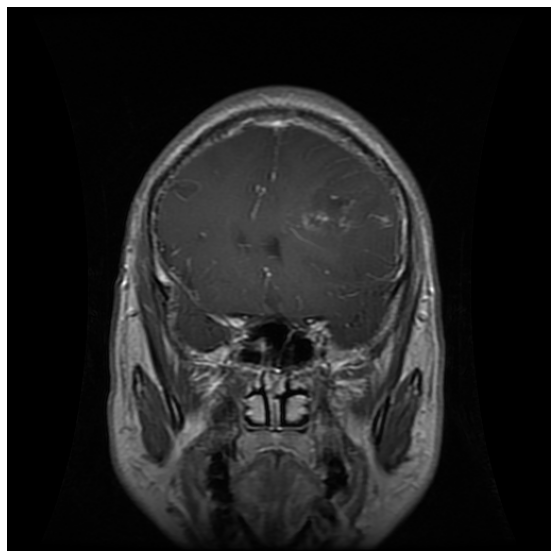

In [16]:
show(img)

In [17]:
msk = read(masks[0])


(512, 512)

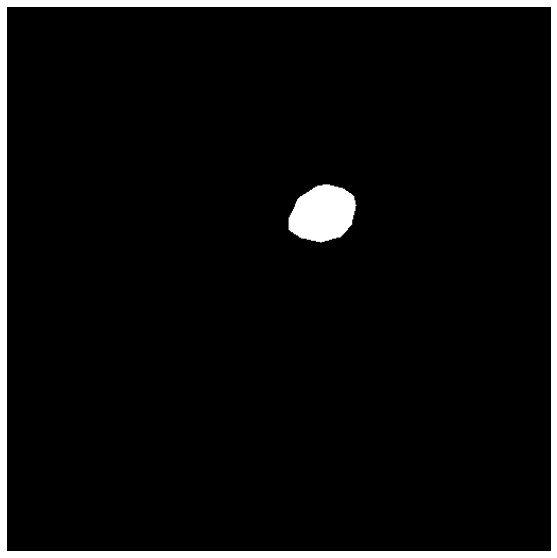

In [18]:
print(msk.shape)
show(msk)

In [19]:
msk = np.stack((msk,msk,msk),axis = 2)

In [20]:
overlayed_img = np.where(msk, (255,0,0), img) # Red overlay (255,0,0)

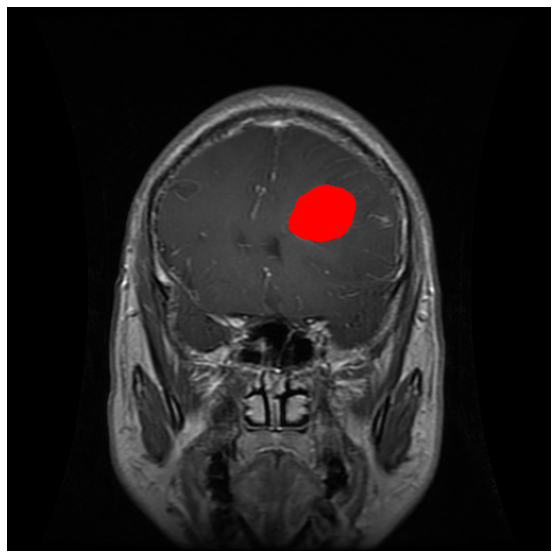

In [21]:
show(overlayed_img)

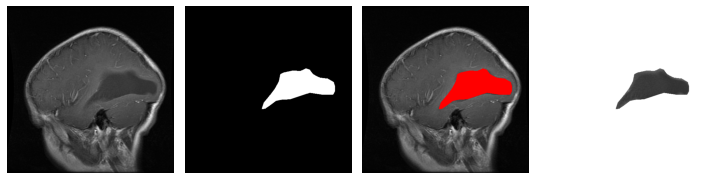

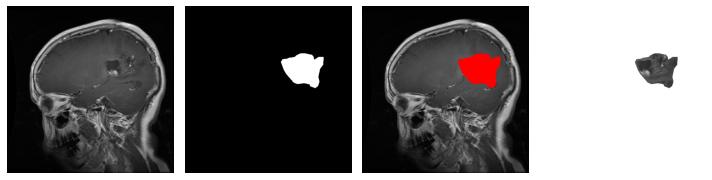

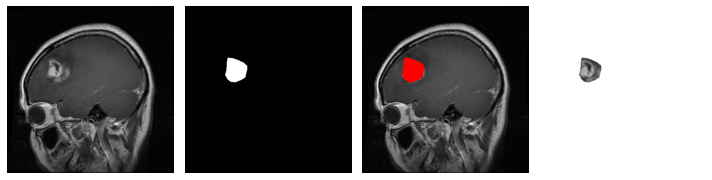

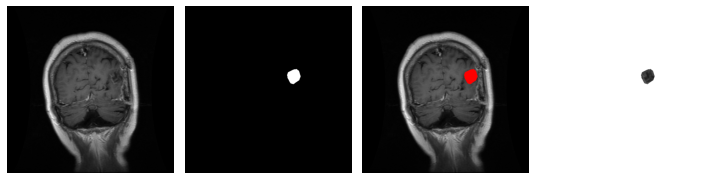

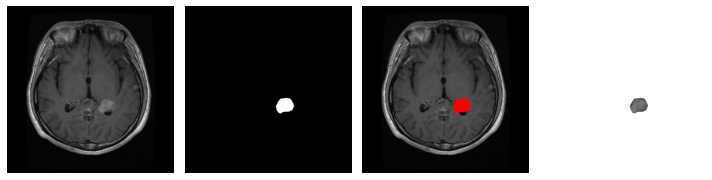

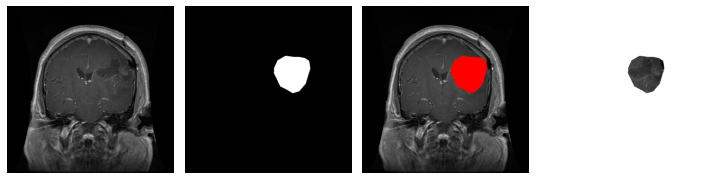

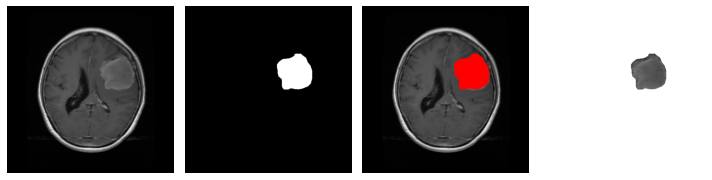

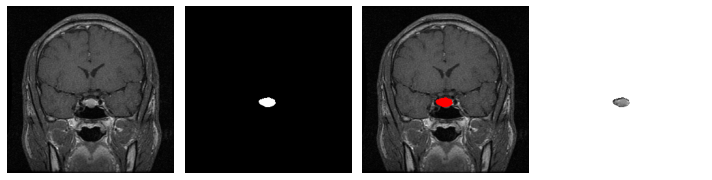

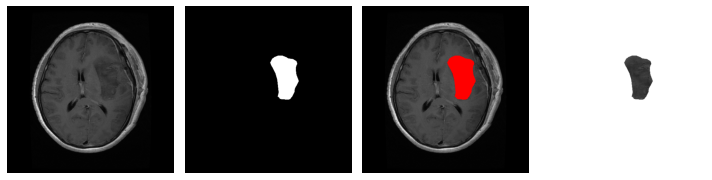

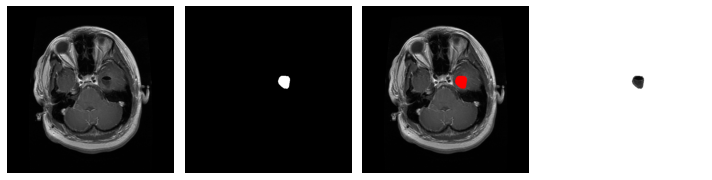

In [22]:

for i in range(10):
  index = np.random.choice(len(images))
  img = read(images[index],1)
  msk = read(masks[index])
  msk_stack = np.stack((msk,msk,msk),axis = 2)
  overlayed_img = np.where(msk_stack, (255,0,0), img) # Red overlay (255,0,0)

  rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
  rgba[:, :, 3] = msk
  subplots([img,msk, overlayed_img, rgba], figsize = (10,10))


# Training and Validation Split

In [23]:
combined = list(zip(images,masks))

In [24]:
trn_files, val_files = train_test_split(combined, random_state = 42,test_size=0.2)

# DataSet class

In [25]:
os.cpu_count()

2

In [26]:
# Image Transformation object
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [27]:
mask_tfms = transforms.ToTensor()

In [28]:
class BrainTumorDataset(Dataset):
  def __init__(self, items, preprocessing = None):
    self.items = items
    self.preprocessing = preprocessing

  def __len__(self):
    return len(self.items)

  def __getitem__(self, ix):
    item = self.items[ix]
    
    ## Getting image and mask path
    image_path = item[0]
    mask_path = item[1]
    
    ### Ingesting image and mask 
    image = read(image_path,1)
    mask = read(mask_path)

    ### resizing image and mask to 224,224. Will start with vgg16 backbone
    image = cv2.resize(image, (224,224))
    mask = cv2.resize(mask, (224,224))
    image = image/255.
    mask = mask/255.
    
    ## Adding depth dimension as image is greyscale
    mask = mask[...,np.newaxis]
    
    # apply preprocessing
    if self.preprocessing:
      sample = self.preprocessing(image = image, mask = mask)
      image, mask = sample['image'], sample['mask']


    return image, mask

  # def collate_fn(self,batch):
  #   ims, masks = list(zip(*batch))
  #   #print(ims)
  #   ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)

  #   ###########  Changing mask to float
  #   #ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).float().to(device)
  #   ce_masks = torch.cat([mask_tfms(mask.copy()/255.)[None] for mask in masks]).float().to(device)
    
  #   return ims, ce_masks

  def choose(self):
    return self[randint(len(self))]







In [29]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [30]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [81]:
ENCODER = 'vgg16_bn'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = device
CLASSES = ['tumor']
preprocessing_fn  = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [82]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [83]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [84]:
train_ds = BrainTumorDataset(items=trn_files, preprocessing = get_preprocessing(preprocessing_fn))


In [85]:
temp_img, temp_msk = train_ds[0]

In [86]:
temp_img.shape

(3, 224, 224)

In [87]:
temp_msk.shape

(1, 224, 224)

In [88]:
valid_ds  =  BrainTumorDataset(items=val_files, preprocessing = get_preprocessing(preprocessing_fn))


In [89]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=4)

In [90]:
loss = smp.losses.DiceLoss(mode = 'binary')

In [91]:
def IOU_Score(output,target,mode = 'binary',threshold = 0.5):
  tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode=mode, threshold=threshold)
  iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
  return iou_score

In [92]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [93]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [94]:
# train model

n_epochs = 75

max_score = 0

log = Report(n_epochs)
for i in range(0, n_epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    log.record( pos=(i+1),trn_dice_loss=train_logs['dice_loss'], trn_iou_score=train_logs['iou_score'], valid_dice_log = valid_logs['dice_loss'], valid_iou_score=valid_logs['iou_score'],end='\r')
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth') 
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

Epoch: 0

valid: 100%|██████████| 613/613 [00:15<00:00, 40.43it/s, dice_loss - 0.7715, iou_score - 0.3336]
EPOCH: 1.000  trn_dice_loss: 0.866  trn_iou_score: 0.218  valid_dice_log: 0.772  valid_iou_score: 0.334  (87.40s - 6467.42s remaining)

Model saved!

Epoch: 1

valid: 100%|██████████| 613/613 [00:13<00:00, 45.89it/s, dice_loss - 0.3975, iou_score - 0.6186]
EPOCH: 2.000  trn_dice_loss: 0.510  trn_iou_score: 0.553  valid_dice_log: 0.398  valid_iou_score: 0.619  (172.92s - 6311.49s remaining)

Model saved!

Epoch: 2

valid: 100%|██████████| 613/613 [00:12<00:00, 47.76it/s, dice_loss - 0.3004, iou_score - 0.664]
EPOCH: 3.000  trn_dice_loss: 0.261  trn_iou_score: 0.683  valid_dice_log: 0.300  valid_iou_score: 0.664  (258.18s - 6196.31s remaining)

Model saved!

Epoch: 3

valid: 100%|██████████| 613/613 [00:13<00:00, 45.59it/s, dice_loss - 0.2549, iou_score - 0.684]
EPOCH: 4.000  trn_dice_loss: 0.187  trn_iou_score: 0.733  valid_dice_log: 0.255  valid_iou_score: 0.684  (345.34s - 6129.87s remaining)

Model saved!

Epoch: 4

valid: 100%|██████████| 613/613 [00:13<00:00, 45.09it/s, dice_loss - 0.239, iou_score - 0.6883]
EPOCH: 5.000  trn_dice_loss: 0.154  trn_iou_score: 0.763  valid_dice_log: 0.239  valid_iou_score: 0.688  (431.55s - 6041.65s remaining)

Model saved!

Epoch: 5

valid: 100%|██████████| 613/613 [00:12<00:00, 47.62it/s, dice_loss - 0.2035, iou_score - 0.7201]
EPOCH: 6.000  trn_dice_loss: 0.129  trn_iou_score: 0.792  valid_dice_log: 0.203  valid_iou_score: 0.720  (517.09s - 5946.52s remaining)

Model saved!

Epoch: 6

valid: 100%|██████████| 613/613 [00:15<00:00, 38.65it/s, dice_loss - 0.2213, iou_score - 0.7024]
EPOCH: 7.000  trn_dice_loss: 0.113  trn_iou_score: 0.812  valid_dice_log: 0.221  valid_iou_score: 0.702  (606.31s - 5889.82s remaining)

Epoch: 7

valid: 100%|██████████| 613/613 [00:13<00:00, 44.54it/s, dice_loss - 0.2134, iou_score - 0.7044]
EPOCH: 8.000  trn_dice_loss: 0.118  trn_iou_score: 0.801  valid_dice_log: 0.213  valid_iou_score: 0.704  (693.10s - 5804.74s remaining)

Epoch: 8

valid: 100%|██████████| 613/613 [00:14<00:00, 41.83it/s, dice_loss - 0.1949, iou_score - 0.7248]
EPOCH: 9.000  trn_dice_loss: 0.093  trn_iou_score: 0.838  valid_dice_log: 0.195  valid_iou_score: 0.725  (780.63s - 5724.63s remaining)

Model saved!

Epoch: 9

valid: 100%|██████████| 613/613 [00:13<00:00, 46.56it/s, dice_loss - 0.1892, iou_score - 0.7307]
EPOCH: 10.000  trn_dice_loss: 0.084  trn_iou_score: 0.853  valid_dice_log: 0.189  valid_iou_score: 0.731  (866.75s - 5633.85s remaining)

Model saved!

Epoch: 10

valid: 100%|██████████| 613/613 [00:12<00:00, 49.13it/s, dice_loss - 0.1879, iou_score - 0.7282]
EPOCH: 11.000  trn_dice_loss: 0.083  trn_iou_score: 0.853  valid_dice_log: 0.188  valid_iou_score: 0.728  (951.83s - 5537.89s remaining)

Epoch: 11

valid: 100%|██████████| 613/613 [00:13<00:00, 46.63it/s, dice_loss - 0.1995, iou_score - 0.7183]
EPOCH: 12.000  trn_dice_loss: 0.088  trn_iou_score: 0.845  valid_dice_log: 0.199  valid_iou_score: 0.718  (1038.23s - 5450.72s remaining)

Epoch: 12

valid: 100%|██████████| 613/613 [00:13<00:00, 44.98it/s, dice_loss - 0.1836, iou_score - 0.7352]
EPOCH: 13.000  trn_dice_loss: 0.074  trn_iou_score: 0.866  valid_dice_log: 0.184  valid_iou_score: 0.735  (1125.39s - 5367.23s remaining)

Model saved!

Epoch: 13

valid: 100%|██████████| 613/613 [00:15<00:00, 39.93it/s, dice_loss - 0.181, iou_score - 0.7364]
EPOCH: 14.000  trn_dice_loss: 0.066  trn_iou_score: 0.880  valid_dice_log: 0.181  valid_iou_score: 0.736  (1213.34s - 5286.71s remaining)

Model saved!

Epoch: 14

valid: 100%|██████████| 613/613 [00:13<00:00, 44.41it/s, dice_loss - 0.1826, iou_score - 0.7344]
EPOCH: 15.000  trn_dice_loss: 0.060  trn_iou_score: 0.890  valid_dice_log: 0.183  valid_iou_score: 0.734  (1299.83s - 5199.32s remaining)

Epoch: 15

valid: 100%|██████████| 613/613 [00:15<00:00, 39.99it/s, dice_loss - 0.181, iou_score - 0.736]
EPOCH: 16.000  trn_dice_loss: 0.056  trn_iou_score: 0.897  valid_dice_log: 0.181  valid_iou_score: 0.736  (1387.84s - 5117.67s remaining)

Epoch: 16

valid: 100%|██████████| 613/613 [00:13<00:00, 46.03it/s, dice_loss - 0.2031, iou_score - 0.7106]
EPOCH: 17.000  trn_dice_loss: 0.059  trn_iou_score: 0.892  valid_dice_log: 0.203  valid_iou_score: 0.711  (1474.71s - 5031.37s remaining)

Epoch: 17

valid: 100%|██████████| 613/613 [00:14<00:00, 41.10it/s, dice_loss - 0.216, iou_score - 0.7019]
EPOCH: 18.000  trn_dice_loss: 0.074  trn_iou_score: 0.866  valid_dice_log: 0.216  valid_iou_score: 0.702  (1563.37s - 4950.67s remaining)

Epoch: 18

valid: 100%|██████████| 613/613 [00:13<00:00, 44.55it/s, dice_loss - 0.19, iou_score - 0.7251]
EPOCH: 19.000  trn_dice_loss: 0.078  trn_iou_score: 0.859  valid_dice_log: 0.190  valid_iou_score: 0.725  (1650.52s - 4864.70s remaining)

Epoch: 19

valid: 100%|██████████| 613/613 [00:13<00:00, 44.53it/s, dice_loss - 0.1801, iou_score - 0.7376]
EPOCH: 20.000  trn_dice_loss: 0.056  trn_iou_score: 0.897  valid_dice_log: 0.180  valid_iou_score: 0.738  (1736.72s - 4775.99s remaining)

Model saved!

Epoch: 20

valid: 100%|██████████| 613/613 [00:13<00:00, 45.86it/s, dice_loss - 0.1789, iou_score - 0.7401]
EPOCH: 21.000  trn_dice_loss: 0.048  trn_iou_score: 0.911  valid_dice_log: 0.179  valid_iou_score: 0.740  (1823.28s - 4688.43s remaining)

Model saved!

Epoch: 21

valid: 100%|██████████| 613/613 [00:13<00:00, 45.04it/s, dice_loss - 0.17, iou_score - 0.7466]
EPOCH: 22.000  trn_dice_loss: 0.044  trn_iou_score: 0.917  valid_dice_log: 0.170  valid_iou_score: 0.747  (1910.83s - 4603.37s remaining)

Model saved!

Epoch: 22

valid: 100%|██████████| 613/613 [00:15<00:00, 39.40it/s, dice_loss - 0.1716, iou_score - 0.7443]
EPOCH: 23.000  trn_dice_loss: 0.042  trn_iou_score: 0.921  valid_dice_log: 0.172  valid_iou_score: 0.744  (1999.03s - 4519.55s remaining)

Epoch: 23

valid: 100%|██████████| 613/613 [00:13<00:00, 45.84it/s, dice_loss - 0.1804, iou_score - 0.7353]
EPOCH: 24.000  trn_dice_loss: 0.041  trn_iou_score: 0.923  valid_dice_log: 0.180  valid_iou_score: 0.735  (2085.05s - 4430.74s remaining)

Epoch: 24

valid: 100%|██████████| 613/613 [00:14<00:00, 43.53it/s, dice_loss - 0.1752, iou_score - 0.7411]
EPOCH: 25.000  trn_dice_loss: 0.040  trn_iou_score: 0.925  valid_dice_log: 0.175  valid_iou_score: 0.741  (2173.00s - 4346.00s remaining)

Epoch: 25

valid: 100%|██████████| 613/613 [00:13<00:00, 43.92it/s, dice_loss - 0.2001, iou_score - 0.7168]
EPOCH: 26.000  trn_dice_loss: 0.042  trn_iou_score: 0.920  valid_dice_log: 0.200  valid_iou_score: 0.717  (2260.56s - 4260.28s remaining)

Decrease decoder learning rate to 1e-5!

Epoch: 26

valid: 100%|██████████| 613/613 [00:13<00:00, 44.27it/s, dice_loss - 0.1847, iou_score - 0.7323]
EPOCH: 27.000  trn_dice_loss: 0.039  trn_iou_score: 0.926  valid_dice_log: 0.185  valid_iou_score: 0.732  (2346.89s - 4172.25s remaining)

Epoch: 27

valid: 100%|██████████| 613/613 [00:13<00:00, 47.08it/s, dice_loss - 0.1802, iou_score - 0.7359]
EPOCH: 28.000  trn_dice_loss: 0.035  trn_iou_score: 0.933  valid_dice_log: 0.180  valid_iou_score: 0.736  (2432.94s - 4083.87s remaining)

Epoch: 28

valid: 100%|██████████| 613/613 [00:14<00:00, 42.51it/s, dice_loss - 0.178, iou_score - 0.7379]
EPOCH: 29.000  trn_dice_loss: 0.033  trn_iou_score: 0.937  valid_dice_log: 0.178  valid_iou_score: 0.738  (2521.10s - 3998.98s remaining)

Epoch: 29

valid: 100%|██████████| 613/613 [00:15<00:00, 38.99it/s, dice_loss - 0.1754, iou_score - 0.7404]
EPOCH: 30.000  trn_dice_loss: 0.032  trn_iou_score: 0.940  valid_dice_log: 0.175  valid_iou_score: 0.740  (2609.28s - 3913.92s remaining)

Epoch: 30

valid: 100%|██████████| 613/613 [00:13<00:00, 44.07it/s, dice_loss - 0.1765, iou_score - 0.7392]
EPOCH: 31.000  trn_dice_loss: 0.031  trn_iou_score: 0.942  valid_dice_log: 0.176  valid_iou_score: 0.739  (2695.68s - 3826.13s remaining)

Epoch: 31

valid: 100%|██████████| 613/613 [00:16<00:00, 38.26it/s, dice_loss - 0.1757, iou_score - 0.7404]
EPOCH: 32.000  trn_dice_loss: 0.029  trn_iou_score: 0.944  valid_dice_log: 0.176  valid_iou_score: 0.740  (2784.52s - 3741.70s remaining)

Epoch: 32

valid: 100%|██████████| 613/613 [00:13<00:00, 44.42it/s, dice_loss - 0.1765, iou_score - 0.7392]
EPOCH: 33.000  trn_dice_loss: 0.028  trn_iou_score: 0.947  valid_dice_log: 0.177  valid_iou_score: 0.739  (2871.52s - 3654.66s remaining)

Epoch: 33

valid: 100%|██████████| 613/613 [00:15<00:00, 39.27it/s, dice_loss - 0.1742, iou_score - 0.7409]
EPOCH: 34.000  trn_dice_loss: 0.028  trn_iou_score: 0.947  valid_dice_log: 0.174  valid_iou_score: 0.741  (2960.70s - 3570.26s remaining)

Epoch: 34

valid: 100%|██████████| 613/613 [00:14<00:00, 43.08it/s, dice_loss - 0.1745, iou_score - 0.7413]
EPOCH: 35.000  trn_dice_loss: 0.027  trn_iou_score: 0.949  valid_dice_log: 0.174  valid_iou_score: 0.741  (3049.05s - 3484.62s remaining)

Epoch: 35

valid: 100%|██████████| 613/613 [00:15<00:00, 40.56it/s, dice_loss - 0.1752, iou_score - 0.7403]
EPOCH: 36.000  trn_dice_loss: 0.027  trn_iou_score: 0.950  valid_dice_log: 0.175  valid_iou_score: 0.740  (3136.74s - 3398.14s remaining)

Epoch: 36

valid: 100%|██████████| 613/613 [00:13<00:00, 44.58it/s, dice_loss - 0.1741, iou_score - 0.7416]
EPOCH: 37.000  trn_dice_loss: 0.026  trn_iou_score: 0.951  valid_dice_log: 0.174  valid_iou_score: 0.742  (3223.93s - 3311.06s remaining)

Epoch: 37

valid: 100%|██████████| 613/613 [00:14<00:00, 43.11it/s, dice_loss - 0.1737, iou_score - 0.742]
EPOCH: 38.000  trn_dice_loss: 0.025  trn_iou_score: 0.952  valid_dice_log: 0.174  valid_iou_score: 0.742  (3312.00s - 3224.84s remaining)

Epoch: 38

valid: 100%|██████████| 613/613 [00:14<00:00, 42.31it/s, dice_loss - 0.1748, iou_score - 0.7407]
EPOCH: 39.000  trn_dice_loss: 0.025  trn_iou_score: 0.953  valid_dice_log: 0.175  valid_iou_score: 0.741  (3400.08s - 3138.54s remaining)

Epoch: 39

valid: 100%|██████████| 613/613 [00:13<00:00, 45.02it/s, dice_loss - 0.176, iou_score - 0.7393]
EPOCH: 40.000  trn_dice_loss: 0.025  trn_iou_score: 0.953  valid_dice_log: 0.176  valid_iou_score: 0.739  (3486.53s - 3050.71s remaining)

Epoch: 40

valid: 100%|██████████| 613/613 [00:14<00:00, 43.38it/s, dice_loss - 0.1746, iou_score - 0.7406]
EPOCH: 41.000  trn_dice_loss: 0.024  trn_iou_score: 0.954  valid_dice_log: 0.175  valid_iou_score: 0.741  (3574.25s - 2964.01s remaining)

Epoch: 41

valid: 100%|██████████| 613/613 [00:14<00:00, 42.61it/s, dice_loss - 0.1777, iou_score - 0.7377]
EPOCH: 42.000  trn_dice_loss: 0.024  trn_iou_score: 0.955  valid_dice_log: 0.178  valid_iou_score: 0.738  (3662.50s - 2877.68s remaining)

Epoch: 42

valid: 100%|██████████| 613/613 [00:14<00:00, 42.86it/s, dice_loss - 0.1775, iou_score - 0.7379]
EPOCH: 43.000  trn_dice_loss: 0.024  trn_iou_score: 0.955  valid_dice_log: 0.178  valid_iou_score: 0.738  (3749.88s - 2790.61s remaining)

Epoch: 43

valid: 100%|██████████| 613/613 [00:13<00:00, 44.91it/s, dice_loss - 0.1757, iou_score - 0.7396]
EPOCH: 44.000  trn_dice_loss: 0.023  trn_iou_score: 0.955  valid_dice_log: 0.176  valid_iou_score: 0.740  (3836.40s - 2702.92s remaining)

Epoch: 44

valid: 100%|██████████| 613/613 [00:14<00:00, 43.41it/s, dice_loss - 0.1779, iou_score - 0.7376]
EPOCH: 45.000  trn_dice_loss: 0.023  trn_iou_score: 0.956  valid_dice_log: 0.178  valid_iou_score: 0.738  (3924.25s - 2616.17s remaining)

Epoch: 45

valid: 100%|██████████| 613/613 [00:14<00:00, 43.38it/s, dice_loss - 0.1762, iou_score - 0.7389]
EPOCH: 46.000  trn_dice_loss: 0.023  trn_iou_score: 0.957  valid_dice_log: 0.176  valid_iou_score: 0.739  (4011.54s - 2529.01s remaining)

Epoch: 46

valid: 100%|██████████| 613/613 [00:15<00:00, 39.40it/s, dice_loss - 0.1781, iou_score - 0.7368]
EPOCH: 47.000  trn_dice_loss: 0.023  trn_iou_score: 0.957  valid_dice_log: 0.178  valid_iou_score: 0.737  (4100.06s - 2442.59s remaining)

Epoch: 47

valid: 100%|██████████| 613/613 [00:13<00:00, 45.19it/s, dice_loss - 0.1757, iou_score - 0.7393]
EPOCH: 48.000  trn_dice_loss: 0.022  trn_iou_score: 0.957  valid_dice_log: 0.176  valid_iou_score: 0.739  (4186.42s - 2354.86s remaining)

Epoch: 48

valid: 100%|██████████| 613/613 [00:15<00:00, 39.44it/s, dice_loss - 0.1766, iou_score - 0.7383]
EPOCH: 49.000  trn_dice_loss: 0.022  trn_iou_score: 0.958  valid_dice_log: 0.177  valid_iou_score: 0.738  (4275.88s - 2268.84s remaining)

Epoch: 49

valid: 100%|██████████| 613/613 [00:14<00:00, 43.13it/s, dice_loss - 0.1768, iou_score - 0.7385]
EPOCH: 50.000  trn_dice_loss: 0.022  trn_iou_score: 0.959  valid_dice_log: 0.177  valid_iou_score: 0.738  (4362.84s - 2181.42s remaining)

Epoch: 50

valid: 100%|██████████| 613/613 [00:15<00:00, 40.28it/s, dice_loss - 0.1761, iou_score - 0.7394]
EPOCH: 51.000  trn_dice_loss: 0.021  trn_iou_score: 0.959  valid_dice_log: 0.176  valid_iou_score: 0.739  (4450.96s - 2094.57s remaining)

Epoch: 51

valid: 100%|██████████| 613/613 [00:13<00:00, 44.02it/s, dice_loss - 0.1758, iou_score - 0.7395]
EPOCH: 52.000  trn_dice_loss: 0.021  trn_iou_score: 0.959  valid_dice_log: 0.176  valid_iou_score: 0.739  (4538.44s - 2007.39s remaining)

Epoch: 52

valid: 100%|██████████| 613/613 [00:14<00:00, 41.78it/s, dice_loss - 0.1768, iou_score - 0.7386]
EPOCH: 53.000  trn_dice_loss: 0.021  trn_iou_score: 0.960  valid_dice_log: 0.177  valid_iou_score: 0.739  (4627.07s - 1920.67s remaining)

Epoch: 53

valid: 100%|██████████| 613/613 [00:13<00:00, 43.90it/s, dice_loss - 0.1776, iou_score - 0.7374]
EPOCH: 54.000  trn_dice_loss: 0.021  trn_iou_score: 0.960  valid_dice_log: 0.178  valid_iou_score: 0.737  (4714.71s - 1833.50s remaining)

Epoch: 54

valid: 100%|██████████| 613/613 [00:15<00:00, 40.58it/s, dice_loss - 0.1761, iou_score - 0.7388]
EPOCH: 55.000  trn_dice_loss: 0.021  trn_iou_score: 0.960  valid_dice_log: 0.176  valid_iou_score: 0.739  (4803.13s - 1746.59s remaining)

Epoch: 55

valid: 100%|██████████| 613/613 [00:14<00:00, 43.09it/s, dice_loss - 0.1766, iou_score - 0.7384]
EPOCH: 56.000  trn_dice_loss: 0.021  trn_iou_score: 0.960  valid_dice_log: 0.177  valid_iou_score: 0.738  (4890.75s - 1659.36s remaining)

Epoch: 56

valid: 100%|██████████| 613/613 [00:13<00:00, 43.97it/s, dice_loss - 0.1764, iou_score - 0.7384]
EPOCH: 57.000  trn_dice_loss: 0.021  trn_iou_score: 0.961  valid_dice_log: 0.176  valid_iou_score: 0.738  (4978.30s - 1572.10s remaining)

Epoch: 57

valid: 100%|██████████| 613/613 [00:14<00:00, 43.47it/s, dice_loss - 0.1774, iou_score - 0.7372]
EPOCH: 58.000  trn_dice_loss: 0.020  trn_iou_score: 0.961  valid_dice_log: 0.177  valid_iou_score: 0.737  (5066.54s - 1485.02s remaining)

Epoch: 58

valid: 100%|██████████| 613/613 [00:14<00:00, 42.42it/s, dice_loss - 0.1767, iou_score - 0.738]
EPOCH: 59.000  trn_dice_loss: 0.020  trn_iou_score: 0.962  valid_dice_log: 0.177  valid_iou_score: 0.738  (5154.98s - 1397.96s remaining)

Epoch: 59

valid: 100%|██████████| 613/613 [00:14<00:00, 43.53it/s, dice_loss - 0.176, iou_score - 0.7391]
EPOCH: 60.000  trn_dice_loss: 0.020  trn_iou_score: 0.962  valid_dice_log: 0.176  valid_iou_score: 0.739  (5242.30s - 1310.58s remaining)

Epoch: 60

valid: 100%|██████████| 613/613 [00:14<00:00, 43.20it/s, dice_loss - 0.1782, iou_score - 0.7367]
EPOCH: 61.000  trn_dice_loss: 0.020  trn_iou_score: 0.962  valid_dice_log: 0.178  valid_iou_score: 0.737  (5329.81s - 1223.24s remaining)

Epoch: 61

valid: 100%|██████████| 613/613 [00:14<00:00, 42.88it/s, dice_loss - 0.1775, iou_score - 0.7378]
EPOCH: 62.000  trn_dice_loss: 0.020  trn_iou_score: 0.962  valid_dice_log: 0.177  valid_iou_score: 0.738  (5417.20s - 1135.86s remaining)

Epoch: 62

valid: 100%|██████████| 613/613 [00:14<00:00, 42.39it/s, dice_loss - 0.1769, iou_score - 0.7384]
EPOCH: 63.000  trn_dice_loss: 0.020  trn_iou_score: 0.962  valid_dice_log: 0.177  valid_iou_score: 0.738  (5504.53s - 1048.48s remaining)

Epoch: 63

valid: 100%|██████████| 613/613 [00:14<00:00, 42.50it/s, dice_loss - 0.1772, iou_score - 0.7376]
EPOCH: 64.000  trn_dice_loss: 0.020  trn_iou_score: 0.962  valid_dice_log: 0.177  valid_iou_score: 0.738  (5591.96s - 961.12s remaining)

Epoch: 64

valid: 100%|██████████| 613/613 [00:14<00:00, 41.45it/s, dice_loss - 0.1766, iou_score - 0.7382]
EPOCH: 65.000  trn_dice_loss: 0.020  trn_iou_score: 0.963  valid_dice_log: 0.177  valid_iou_score: 0.738  (5679.85s - 873.82s remaining)

Epoch: 65

valid: 100%|██████████| 613/613 [00:14<00:00, 41.59it/s, dice_loss - 0.1776, iou_score - 0.7374]
EPOCH: 66.000  trn_dice_loss: 0.020  trn_iou_score: 0.963  valid_dice_log: 0.178  valid_iou_score: 0.737  (5767.92s - 786.53s remaining)

Epoch: 66

valid: 100%|██████████| 613/613 [00:14<00:00, 43.53it/s, dice_loss - 0.1772, iou_score - 0.7379]
EPOCH: 67.000  trn_dice_loss: 0.019  trn_iou_score: 0.964  valid_dice_log: 0.177  valid_iou_score: 0.738  (5855.01s - 699.11s remaining)

Epoch: 67

valid: 100%|██████████| 613/613 [00:14<00:00, 42.53it/s, dice_loss - 0.1774, iou_score - 0.738]
EPOCH: 68.000  trn_dice_loss: 0.019  trn_iou_score: 0.964  valid_dice_log: 0.177  valid_iou_score: 0.738  (5942.00s - 611.68s remaining)

Epoch: 68

valid: 100%|██████████| 613/613 [00:14<00:00, 42.13it/s, dice_loss - 0.1768, iou_score - 0.7382]
EPOCH: 69.000  trn_dice_loss: 0.019  trn_iou_score: 0.963  valid_dice_log: 0.177  valid_iou_score: 0.738  (6029.41s - 524.30s remaining)

Epoch: 69

valid: 100%|██████████| 613/613 [00:14<00:00, 41.00it/s, dice_loss - 0.1752, iou_score - 0.7393]
EPOCH: 70.000  trn_dice_loss: 0.019  trn_iou_score: 0.963  valid_dice_log: 0.175  valid_iou_score: 0.739  (6117.26s - 436.95s remaining)

Epoch: 70

valid: 100%|██████████| 613/613 [00:14<00:00, 42.22it/s, dice_loss - 0.1765, iou_score - 0.738]
EPOCH: 71.000  trn_dice_loss: 0.019  trn_iou_score: 0.964  valid_dice_log: 0.177  valid_iou_score: 0.738  (6205.98s - 349.63s remaining)

Epoch: 71

valid: 100%|██████████| 613/613 [00:15<00:00, 38.48it/s, dice_loss - 0.1763, iou_score - 0.7386]
EPOCH: 72.000  trn_dice_loss: 0.019  trn_iou_score: 0.965  valid_dice_log: 0.176  valid_iou_score: 0.739  (6295.00s - 262.29s remaining)

Epoch: 72

valid: 100%|██████████| 613/613 [00:14<00:00, 42.56it/s, dice_loss - 0.1769, iou_score - 0.7385]
EPOCH: 73.000  trn_dice_loss: 0.019  trn_iou_score: 0.964  valid_dice_log: 0.177  valid_iou_score: 0.739  (6383.35s - 174.89s remaining)

Epoch: 73

valid: 100%|██████████| 613/613 [00:16<00:00, 37.65it/s, dice_loss - 0.1766, iou_score - 0.7379]
EPOCH: 74.000  trn_dice_loss: 0.018  trn_iou_score: 0.965  valid_dice_log: 0.177  valid_iou_score: 0.738  (6473.30s - 87.48s remaining)

Epoch: 74

valid: 100%|██████████| 613/613 [00:14<00:00, 41.86it/s, dice_loss - 0.1766, iou_score - 0.7381]
EPOCH: 75.000  trn_dice_loss: 0.018  trn_iou_score: 0.965  valid_dice_log: 0.177  valid_iou_score: 0.738  (6560.85s - 0.00s remaining)

100%|██████████| 176/176 [00:00<00:00, 27289.10it/s]


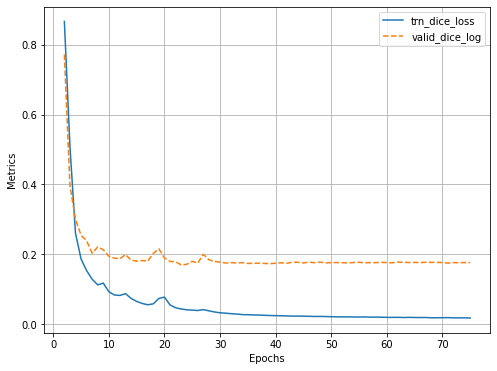

In [95]:
log.plot_epochs(['trn_dice_loss','valid_dice_log'])

100%|██████████| 176/176 [00:00<00:00, 18891.81it/s]


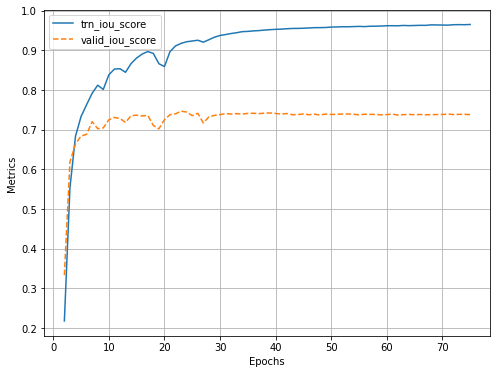

In [96]:
log.plot_epochs(['trn_iou_score','valid_iou_score'])

In [97]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [98]:
img, mask = valid_ds.choose()

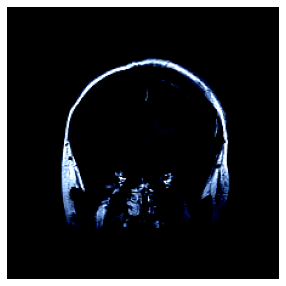

In [99]:
show(img)

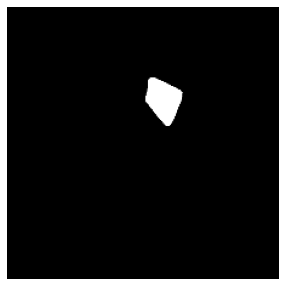

In [100]:
show(mask.reshape((224,224)))

In [101]:
x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)

In [102]:
pr_mask = best_model.predict(x_tensor)

In [103]:
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

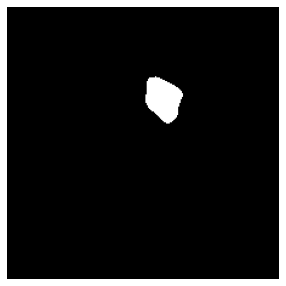

In [104]:
show(pr_mask)

# Inferencing on new image

In [105]:
index = np.random.choice(len(combined))

In [106]:
img_path, mask_path = combined[index]

In [107]:
img_inference = read(img_path,1)
mask = read(mask_path)

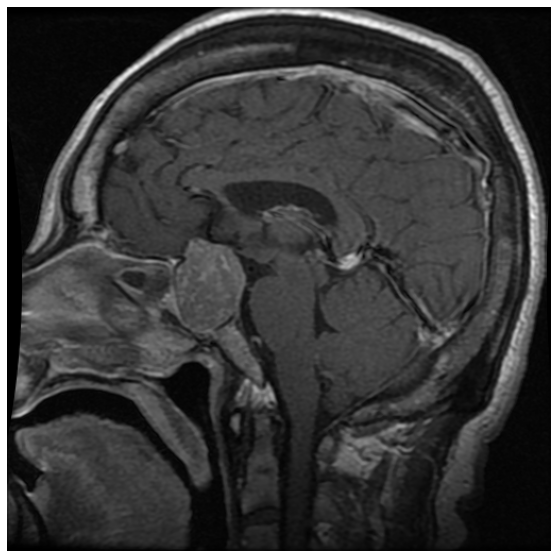

In [108]:
show(img_inference)

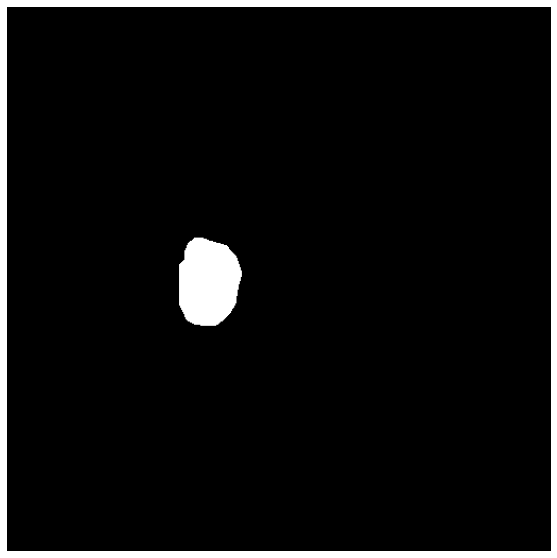

In [109]:
show(mask)

In [110]:
prepro_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [111]:
img_inference = cv2.resize(img_inference, (224,224))

In [112]:
img = img_inference.copy()

In [113]:
img = img/255.

In [114]:
img = np.array(img)

In [115]:
img = prepro_fn(img)

In [116]:
img = to_tensor(img)

In [117]:
x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)

In [118]:
pr_mask = best_model.predict(x_tensor)

In [119]:
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

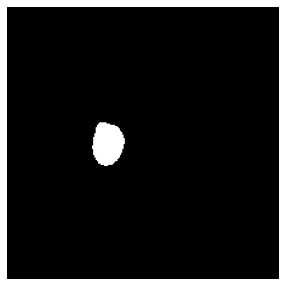

In [120]:
show(pr_mask)

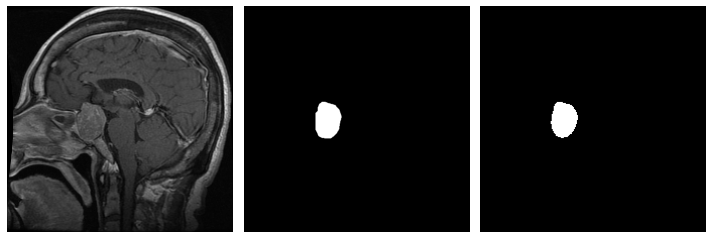

In [121]:
subplots([img_inference, mask, pr_mask],figsize=(10,10))

# Inference on multiple images

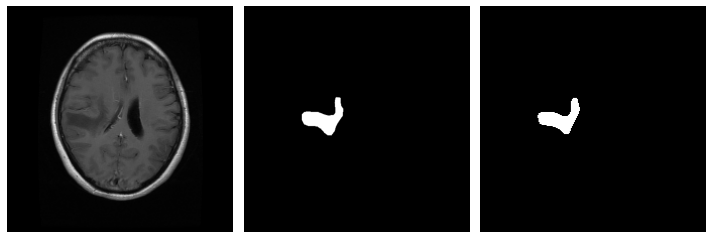

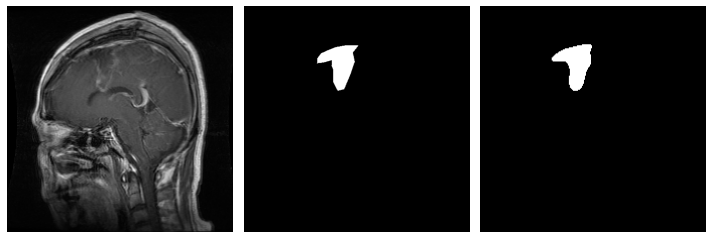

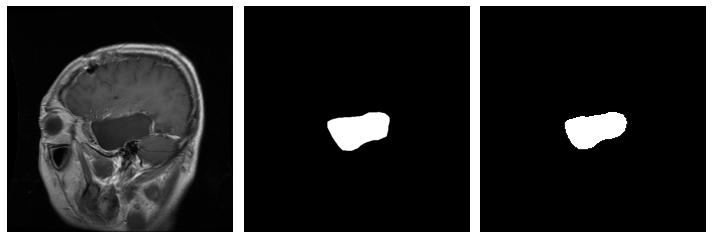

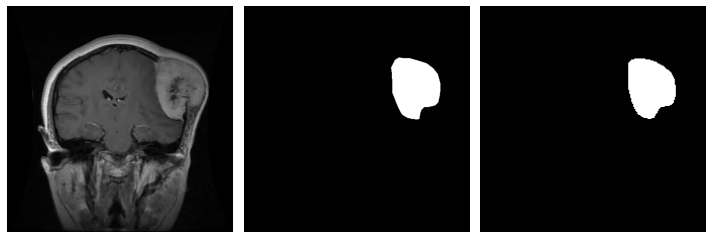

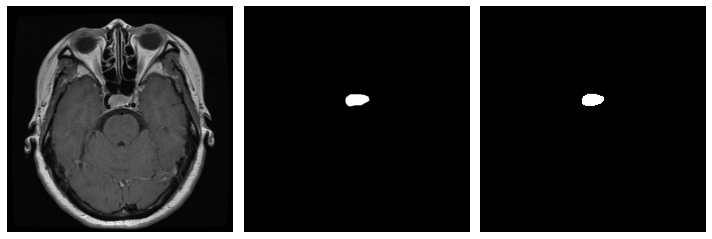

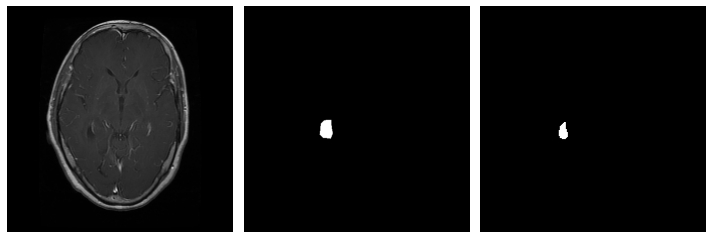

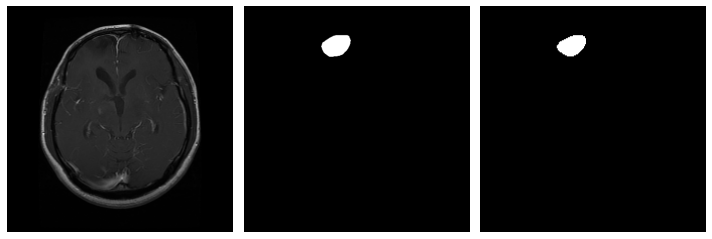

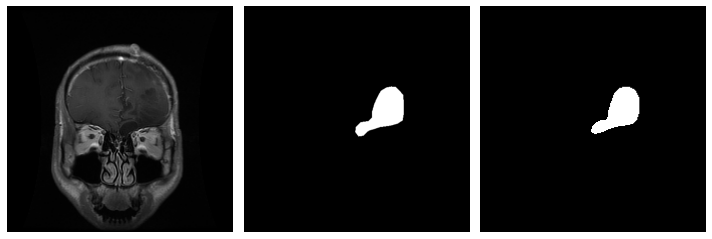

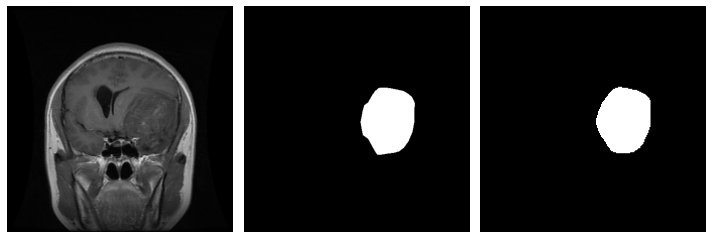

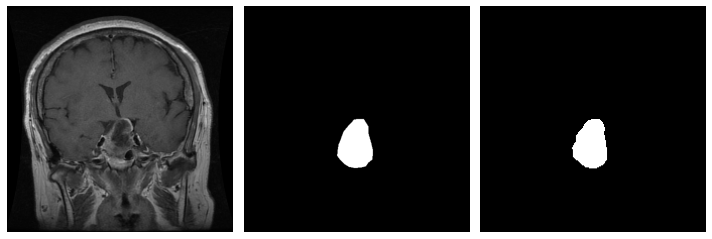

In [122]:
for i in range(10):
  index = np.random.choice(len(combined))
  img_path, mask_path = combined[index]
  img_inference = read(img_path,1)
  mask = read(mask_path)
  prepro_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
  img_inference = cv2.resize(img_inference, (224,224))
  img = img_inference.copy()
  img = img/255.
  img = np.array(img)
  img = prepro_fn(img)
  img = to_tensor(img)
  x_tensor = torch.from_numpy(img).to("cpu").unsqueeze(0) ### cpu inferecning
  pr_mask = best_model.to("cpu").predict(x_tensor)  ## cpu inferencing
  pr_mask = (pr_mask.squeeze().cpu().numpy().round())
  subplots([img_inference, mask, pr_mask],figsize=(10,10))